In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Loading the data

In [2]:
# import necessary libraries
import numpy as np 
import pandas as pd 

# Load data from CSV files
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_test = pd.read_csv("/kaggle/input/titanic/test.csv")
target = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")

In [3]:
# Display last 5 rows of the dataframe to get an idea about its nature
df_train.tail()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.00,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.00,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.45,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.00,C148,C
890,891,0,3,"Dooley, Mr. Patrick",male,32.0,0,0,370376,7.75,NaN,Q


# Handling missing values

In [4]:
# Check for missing values in the training set
df_train.isna().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# "Embarked" column only has 2 missing values so lets drop them
df_train = df_train.dropna(subset=['Embarked'])

# Since the "Age" and "Cabin" collumns contains a large ammount of NaN values I decided to impute them 

# Splitting the data into X/Y training and test sets

In [6]:
Y_train = df_train['Survived']
X_train = df_train.drop(['Name', 'PassengerId', 'Survived'], axis=1)
Y_test = target['Survived']
X_test = df_test.drop(['Name', 'PassengerId'], axis=1)

# Preprocessing numerical and categorical variables

In [7]:
# Display info about the training data and its columns
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 889 entries, 0 to 890
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Sex       889 non-null    object 
 2   Age       712 non-null    float64
 3   SibSp     889 non-null    int64  
 4   Parch     889 non-null    int64  
 5   Ticket    889 non-null    object 
 6   Fare      889 non-null    float64
 7   Cabin     202 non-null    object 
 8   Embarked  889 non-null    object 
dtypes: float64(2), int64(3), object(4)
memory usage: 69.5+ KB


In [8]:
from sklearn.compose import make_column_selector as selector

# Select numerical and categorical columns
num_col_selector = selector(dtype_exclude=object)
cat_col_selector = selector(dtype_include=object) 

num_col, cat_col = num_col_selector(X_train), cat_col_selector(X_train)

In [9]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer

# Initialize a preprocessor for both collumn types 
encoder = OneHotEncoder(handle_unknown="ignore")
scaler = StandardScaler()

# Initialize imputers as well
num_imputer = SimpleImputer(strategy='mean')
cat_imputer = SimpleImputer(strategy='most_frequent')

In [10]:
from sklearn.pipeline import make_pipeline

# Place them inside pipelines
numeric_transformer = make_pipeline(num_imputer, scaler)
categorical_transformer = make_pipeline(cat_imputer, encoder)

In [11]:
from sklearn.compose import ColumnTransformer

# Initialize the main preprocessor
preprocessor = ColumnTransformer([ ('num', numeric_transformer, num_col), ('cat', categorical_transformer, cat_col) ])

# Testing multiple ML classifiers and comparing their accuracy scores

In [12]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression

# Initializing the models 
model_KNN = make_pipeline(preprocessor, KNeighborsClassifier())
model_DTC = make_pipeline(preprocessor, DecisionTreeClassifier())
model_SVC = make_pipeline(preprocessor, SVC())
model_LR = make_pipeline(preprocessor, LogisticRegression())

In [13]:
# Training the models
model_KNN.fit(X_train, Y_train)
model_DTC.fit(X_train, Y_train)
model_SVC.fit(X_train, Y_train)
_ = model_LR.fit(X_train, Y_train)

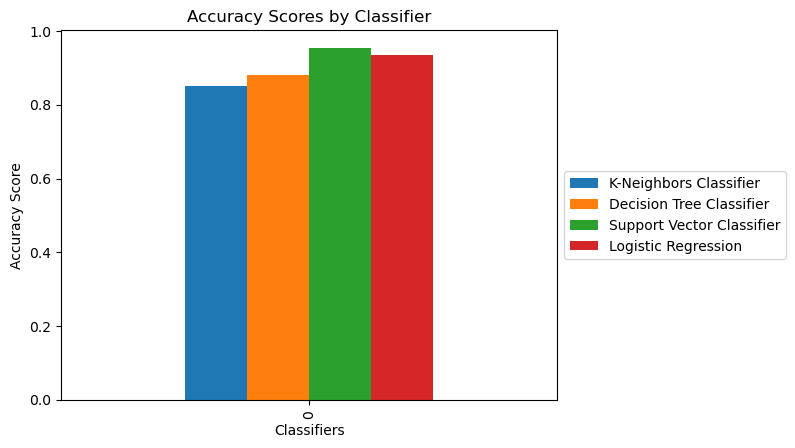

In [17]:
import matplotlib.pyplot as plt
# Display the accuracy scores for each classifier.
results = pd.DataFrame(zip([model_KNN.score(X_test, Y_test)],
                 [model_DTC.score(X_test, Y_test)],
                 [model_SVC.score(X_test, Y_test)],
                 [model_LR.score(X_test, Y_test)]
                ),
             columns=['K-Neighbors Classifier',
                      'Decision Tree Classifier',
                      'Support Vector Classifier',
                      'Logistic Regression']
            )

plot = results.plot.bar()
plt.title('Accuracy Scores by Classifier')
plt.xlabel('Classifiers')
plt.ylabel('Accuracy Score')
plot.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

In [18]:
# Save the output
output = pd.DataFrame(zip(df_test['PassengerId'], model_SVC.predict(X_test)), columns=["PassengerId", "Survived"])
output.to_csv("/kaggle/working/output.csv")